In [15]:
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical
USE_CUDA = False


In [16]:
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
class TSPDataset(Dataset):
    
    def __init__(self, num_nodes, num_samples, random_seed=111):
        super(TSPDataset, self).__init__()
        torch.manual_seed(random_seed)

        self.data_set = []
        for l in tqdm(range(num_samples)):
            x = torch.FloatTensor(num_nodes, 2).uniform_(0, 1)
            self.data_set.append(x)

        self.size = len(self.data_set)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return idx, self.data_set[idx]

In [18]:
train_loader = DataLoader(TSPDataset(20, 1000), batch_size=32, shuffle=True, num_workers=1)
for  (a, b) in train_loader:
    print(a)
    break

100%|██████████| 1000/1000 [00:00<00:00, 140512.70it/s]


tensor([895, 431, 584, 234, 483,  40, 235, 166,  76, 268, 774, 623, 164, 412,
        267, 967, 674, 116, 700, 627, 564, 696,  26, 755, 713, 899, 415, 682,
         81, 428, 953, 839])


In [19]:
len(TSPDataset(20, 1000))

100%|██████████| 1000/1000 [00:00<00:00, 102600.39it/s]


1000

In [20]:
train_size = 100000
val_size = 10000

In [21]:
train_20_dataset = TSPDataset(20, train_size)
val_20_dataset   = TSPDataset(20, val_size)

100%|██████████| 10000/10000 [00:00<00:00, 117203.53it/s]


In [22]:
def reward(sample_solution, USE_CUDA=False):
    """
    Args:
        sample_solution seq_len of [batch_size]
    """
    batch_size = sample_solution[0].size(0)
    n = len(sample_solution)
    tour_len = Variable(torch.zeros([batch_size]))
    

    for i in range(n - 1):
        tour_len += torch.norm(sample_solution[i] - sample_solution[i + 1], dim=1)
    
    tour_len += torch.norm(sample_solution[n - 1] - sample_solution[0], dim=1)

    return tour_len

In [23]:
class Attention(nn.Module):
    def __init__(self, hidden_size, use_tanh=False, C=10, name='Bahdanau', use_cuda=USE_CUDA):
        super(Attention, self).__init__()
        
        self.use_tanh = use_tanh
        self.C = C
        self.name = name
        self.W_query = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_ref   = nn.Linear(hidden_size, hidden_size, bias=False)
        self.V = nn.Linear(hidden_size, 1, bias=False)
        
    def forward(self, query, ref):
        """
        Args: 
            query: [batch_size x hidden_size]
            ref:   [batch_size x seq_len x hidden_size]
        """
        
        batch_size = ref.size(0)
        seq_len    = ref.size(1)
        query = self.W_query(query).unsqueeze(1).repeat(1, seq_len, 1)  # [batch_size x seq_len x hidden_size]
        ref = self.W_ref(ref)  # [batch_size x seq_len x hidden_size] 
        logits = self.V(torch.tanh(query + ref)).squeeze(-1)
        logits = self.C * F.tanh(logits)
        return ref, logits

In [24]:
r = torch.ones(9, 7, 32)

att = Attention(32)
ref, logit = att(torch.ones(9, 32), r)

r = torch.softmax(logit, -1)

r.shape

/home/ita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


torch.Size([9, 7])

In [25]:
class GraphEmbedding(nn.Module):
    def __init__(self, input_size, embedding_size, use_cuda=USE_CUDA):
        super(GraphEmbedding, self).__init__()
        self.embedding_size = embedding_size
        self.use_cuda = use_cuda
        
        self.embedding = nn.Linear(input_size, embedding_size)
    def forward(self, inputs):
        return self.embedding(inputs)

In [26]:
x = GraphEmbedding(32, 16)
q = x(torch.ones(2,3, 32))
print(q)

tensor([[[ 0.4630, -0.2604,  0.3016,  0.1123,  0.0773, -1.0698, -0.2132,
          -0.4268,  0.3135, -0.7142,  0.1052,  0.0151,  0.6963, -0.4468,
          -0.2605,  0.0476],
         [ 0.4630, -0.2604,  0.3016,  0.1123,  0.0773, -1.0698, -0.2132,
          -0.4268,  0.3135, -0.7142,  0.1052,  0.0151,  0.6963, -0.4468,
          -0.2605,  0.0476],
         [ 0.4630, -0.2604,  0.3016,  0.1123,  0.0773, -1.0698, -0.2132,
          -0.4268,  0.3135, -0.7142,  0.1052,  0.0151,  0.6963, -0.4468,
          -0.2605,  0.0476]],

        [[ 0.4630, -0.2604,  0.3016,  0.1123,  0.0773, -1.0698, -0.2132,
          -0.4268,  0.3135, -0.7142,  0.1052,  0.0151,  0.6963, -0.4468,
          -0.2605,  0.0476],
         [ 0.4630, -0.2604,  0.3016,  0.1123,  0.0773, -1.0698, -0.2132,
          -0.4268,  0.3135, -0.7142,  0.1052,  0.0151,  0.6963, -0.4468,
          -0.2605,  0.0476],
         [ 0.4630, -0.2604,  0.3016,  0.1123,  0.0773, -1.0698, -0.2132,
          -0.4268,  0.3135, -0.7142,  0.1052,  0.0

In [27]:
class PointerNet(nn.Module):
    def __init__(self, 
            embedding_size,
            hidden_size,
            seq_len,
            n_glimpses,
            tanh_exploration,
            use_tanh,
            attention,
            use_cuda=USE_CUDA):
        super(PointerNet, self).__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size    = hidden_size
        self.n_glimpses     = n_glimpses
        self.seq_len        = seq_len
        self.use_cuda       = use_cuda
        
        
        self.embedding = GraphEmbedding(2, embedding_size, use_cuda=use_cuda)
        self.encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.pointer = Attention(hidden_size, use_tanh=use_tanh, C=tanh_exploration, name=attention, use_cuda=use_cuda)
        self.glimpse = Attention(hidden_size, use_tanh=False, name=attention, use_cuda=use_cuda)
        
        self.decoder_start_input = nn.Parameter(torch.FloatTensor(embedding_size))
        self.decoder_start_input.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
        
    def apply_mask_to_logits(self, logits, mask, idxs): 
        batch_size = logits.size(0)
        clone_mask = mask.clone()
        if idxs is not None:
            clone_mask[[i for i in range(batch_size)], idxs.data] = 1
            logits[clone_mask] = -np.inf
        return logits, clone_mask
            
    def forward(self, inputs):
        """
        Args: 
            inputs: [batch_size x seq_len x 2]
        """
        batch_size = inputs.size(0)
        seq_len    = inputs.size(1)
        assert seq_len == self.seq_len
        
        embedded = self.embedding(inputs)
        encoder_outputs, (hidden, context) = self.encoder(embedded)
        
        
        prev_probs = []
        prev_idxs = []
        mask = torch.zeros(batch_size, seq_len, dtype=torch.bool)
        idxs = None      
        decoder_input = self.decoder_start_input.unsqueeze(0).repeat(batch_size, 1)
       
        for i in range(seq_len):
            _, (hidden, context) = self.decoder(decoder_input.unsqueeze(1), (hidden, context))
            
            query = hidden.squeeze(0)
            for i in range(self.n_glimpses):
                ref, logits = self.glimpse(query, encoder_outputs)
                logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
                
                query = torch.matmul(ref.transpose(-1, -2), F.softmax(logits, dim=-1).unsqueeze(-1)).squeeze(-1)
                
            _, logits = self.pointer(query, encoder_outputs)
            logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
            probs = F.softmax(logits, dim=-1)
            cat = Categorical(probs)
            
            idxs = cat.sample()
            log_probs = cat.log_prob(idxs)
            dec_input = embedded.gather(1, idxs[:, None, None].repeat(1, 1, self.hidden_size)).squeeze(1)
            prev_probs.append(log_probs)
            prev_idxs.append(idxs)
            
        return torch.stack( prev_probs, 1), torch.stack(prev_idxs, 1)


In [28]:
ret = PointerNet(32, 32, 20, 1, 10, True, 'bahanadu')
x = torch.FloatTensor(17, 20, 2).uniform_(0, 1)
print(x.shape)

torch.Size([17, 20, 2])


In [29]:
prev_probs, prev_idxs = ret(x)
prev_probs.shape,prev_idxs.shape

(torch.Size([17, 20]), torch.Size([17, 20]))

In [30]:
class CombinatorialRL(nn.Module):
    def __init__(self, 
            embedding_size,
            hidden_size,
            seq_len,
            n_glimpses,
            tanh_exploration,
            use_tanh,
            attention,
            use_cuda=USE_CUDA):
        super(CombinatorialRL, self).__init__()
        self.use_cuda = use_cuda
        
        self.actor = PointerNet(
                embedding_size,
                hidden_size,
                seq_len,
                n_glimpses,
                tanh_exploration,
                use_tanh,
                attention,
                use_cuda)
    def reward(self, sample_solution, USE_CUDA=False):
        """
        Args:
            sample_solution seq_len of [batch_size]
            torch.LongTensor [batch_size x seq_len x 2]
        """
        #여기 다시 한 번 확인
        batch_size, seq_len, _ = sample_solution.size()
        tour_len = Variable(torch.zeros([batch_size]))
        for i in range(seq_len - 1):
            tour_len += torch.norm(sample_solution[:, i, :] - sample_solution[:, i + 1, :], dim=-1)

        tour_len += torch.norm(sample_solution[:, seq_len - 1, :] - sample_solution[:, 0, :], dim=-1)

        return tour_len
    
    
    def forward(self, inputs):
        """
        Args:
            inputs: [batch_size, input_size, seq_len]
        """
        batch_size = inputs.size(0)
        input_size = inputs.size(1)
        seq_len    = inputs.size(2)
        
        probs, actions = self.actor(inputs)
        inpts = inputs.gather(1, actions.unsqueeze(2).repeat(1, 1, 2))
        R = self.reward(inputs.gather(1, actions.unsqueeze(2).repeat(1, 1, 2)), self.use_cuda)
        
        return R, probs, actions

In [31]:
ret = CombinatorialRL(32, 32, 20, 2, 10, True, 'bahanadu')
x = torch.FloatTensor(17, 20, 2).uniform_(0, 1)
print(x.shape)

torch.Size([17, 20, 2])


In [32]:
R, action_probs, actions = ret(x)
print(R.shape, action_probs.shape)
print(x.shape, prev_idxs.shape)

torch.Size([17]) torch.Size([17, 20])
torch.Size([17, 20, 2]) torch.Size([17, 20])


In [33]:
r = x.gather(1, prev_idxs.unsqueeze(2).repeat(1, 1, 2))

In [34]:
prev_idxs[1][16]

tensor(3)

In [35]:
x[1][14],r[1][16]

(tensor([0.6866, 0.1706]), tensor([0.1262, 0.4393]))

In [36]:
embedding_size = 128
hidden_size    = 128
n_glimpses = 1
tanh_exploration = 10
use_tanh = True

beta = 0.9
max_grad_norm = 2.

In [37]:
tsp_20_model = CombinatorialRL(
        embedding_size,
        hidden_size,
        20,
        n_glimpses, 
        tanh_exploration,
        use_tanh,
        attention="Bahdanau",
        use_cuda=False)

In [53]:
class TrainModel:
    def __init__(self, model, train_dataset, val_dataset, batch_size=128, threshold=None, max_grad_norm=2.):
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset   = val_dataset
        self.batch_size = batch_size
        self.threshold = threshold
        self.num_tr_data = len(train_dataset)
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
        self.val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

        self.actor_optim   = optim.Adam(model.actor.parameters(), lr=1e-4)
        self.max_grad_norm = max_grad_norm
        
        self.train_tour = []
        self.val_tour   = []
        
        self.epochs = 0
    
    def train_and_validate(self, n_epochs):
        critic_exp_mvg_avg = torch.zeros(self.num_tr_data)

        for epoch in range(n_epochs):
            for batch_id, (indices, sample_batch) in enumerate(self.train_loader):
                self.model.train()
                for rollout in range(5):
                    inputs = Variable(sample_batch)
                    inputs = inputs
                    R, probs, actions = self.model(inputs)
                    critic_exp_mvg_avg[indices] = (critic_exp_mvg_avg[indices] * beta) + ((1. - beta) * R)

                    advantage = R - critic_exp_mvg_avg[indices]

                    logprobs = torch.sum(probs, dim=-1)
                    logprobs[logprobs < -100] = -100
                    reinforce = advantage * logprobs
                    actor_loss = reinforce.mean()

                    self.actor_optim.zero_grad()
                    actor_loss.backward()
                    torch.nn.utils.clip_grad_norm(self.model.actor.parameters(), float(self.max_grad_norm), norm_type=2)

                    self.actor_optim.step()

                    critic_exp_mvg_avg = critic_exp_mvg_avg.detach()
                    self.train_tour.append(R.mean().data)

                if batch_id % 10 == 0:
                    self.plot(self.epochs)

                if batch_id % 100 == 0:    

                    self.model.eval()
                    for _, val_batch in self.val_loader:
                        inputs = Variable(val_batch)
                        inputs = inputs

                        R, probs, actions = self.model(inputs)
                        self.val_tour.append(R.mean().data)

            if self.threshold and self.train_tour[-1] < self.threshold:
                print("EARLY STOPPAGE!")
                break
                
            self.epochs += 1
                
    def plot(self, epoch):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('train tour length: epoch %s reward %s' % (epoch, self.train_tour[-1] if len(self.train_tour) else 'collecting'))
        plt.plot(self.train_tour)
        plt.grid()
        plt.subplot(132)
        plt.title('val tour length: epoch %s reward %s' % (epoch, self.val_tour[-1] if len(self.val_tour) else 'collecting'))
        plt.plot(self.val_tour)
        plt.grid()
        plt.show()

In [54]:
tsp_20_train = TrainModel(tsp_20_model, 
                        train_20_dataset, 
                        val_20_dataset, 
                        threshold=3.99)

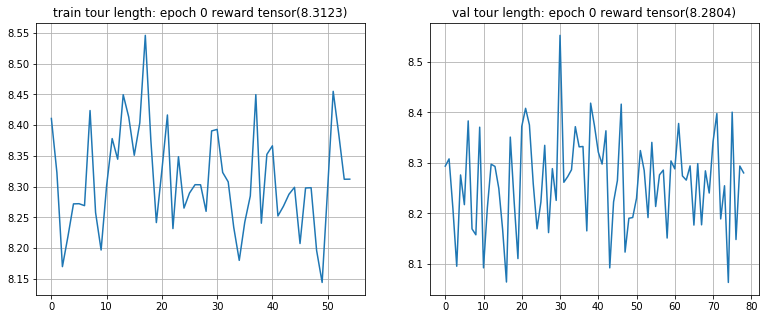

In [ ]:
tsp_20_train.train_and_validate(10)